The notebook is organised under the following headings:</br >
1. Importing necessary packages
2. Data Loading and Preparation
3. UNET Model
4. Preparing submission file
5. Inference code: Loading model weights and testing it on test file

The cells (containing code) under the first four headings are for training the model, saving the model and testing it on the 40% of the test data provided.

The cells (containing code) under the last (5th) heading contain inference code for loading the saved model and testing it on 60% of the remaining test data.

# Importing necessary packages

In [1]:
# In this project, we have used wandb (weights and biases)

!pip install wandb -q

In [12]:
# installing the packages

import os
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from numpy import asarray
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
# Login into the wandb account

import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Data Loading and Preparation

In [10]:
# loading the train and test data paths on kaggle platfform in the form of strings

masked_train_path = '/kaggle/input/photo-reconstruction/Dataset/Training_Data/'
unmasked_train_path = '/kaggle/input/photo-reconstruction/Dataset/Training_Data/'
masked_test_path = '/kaggle/input/photo-reconstruction/Dataset/Testing_Data/'

In [6]:
# This is a function which is used to load the data from the train and test paths defined in the above cell. It
# first checks if the file in a particular folder is an image file or not. If it is an image file, then it put 
# it in a list after converting into a numpy array of size (256, 256, 3)


# Here, we are using "Image.open(...)" method from the package PIL to read an image file. Hence, the channel order
# is (R, G, B) as opposed to opencv method in which order is (B, G, R).

def load_data(path, animal = '', mask = ''):
    Folder = path + animal + mask
    list_images = []
    for File_name in os.listdir(Folder):
        if File_name.endswith('jpeg') or File_name.endswith('jpg') or File_name.endswith('png'):
            img = Image.open(os.path.join(Folder,File_name))
            if img is not None:
                list_images.append(asarray(img))
    return list_images

In [7]:
# Here, we have used the function "load_data(...) defined in the above cell to load the image arrays in the lists 
# which are defined on the name of animals."

masked_Cat = load_data(masked_train_path, 'Cat/', 'Masked_Train/')
masked_Dog = load_data(masked_train_path, 'Dog/', 'Masked_Train/')
masked_Elephant = load_data(masked_train_path, 'Elephant/', 'Masked_Train/')
masked_Tiger = load_data(masked_train_path, 'Tiger/', 'Masked_Train/')

Unmasked_Cat = load_data(unmasked_train_path, 'Cat/', 'Unmasked_Train/')
Unmasked_Dog = load_data(unmasked_train_path, 'Dog/', 'Unmasked_Train/')
Unmasked_Elephant = load_data(unmasked_train_path, 'Elephant/', 'Unmasked_Train/')
Unmasked_Tiger = load_data(unmasked_train_path, 'Tiger/', 'Unmasked_Train/')


In [8]:
# Here, we created one masked list by combining all the masked lists containing images of animals

masked_Total = masked_Cat + masked_Dog + masked_Elephant + masked_Tiger
x_train_masked = asarray(masked_Total)

In [9]:
# The shape of array is (7000, 256, 256, 3) i.e. it represents that it has 7000 image arrays each of size 
# (256, 256, 3)

print(x_train_masked.shape)
print(x_train_masked[0].shape)

(7000, 256, 256, 3)
(256, 256, 3)


In [10]:
# Here, we created one Unmasked list by combining all the unmasked lists containing images of animals

Unmasked_Total = Unmasked_Cat + Unmasked_Dog + Unmasked_Elephant + Unmasked_Tiger
y_train_Unmasked = asarray(Unmasked_Total)

In [11]:
print(y_train_Unmasked.shape)

(7000, 256, 256, 3)


In [12]:
""" This is a class which prepares the data in the format required by the model. It takes input two numpy arrays.
    The first array is the array of 7000 masked images (images with holes) each with size (256, 256, 3). The 
    second array is the numpy array of 7000 unmasked images (original images) each of size (256, 256, 3).
    
    The output is an object of this class which contain sets of tuples of (masked image array, unmasked original 
    image array) and the size of each set is 32 which is the batch size. Hence, it contains these tuples in batches. 
    Also, the masked image array and its corresponding unmasked original image array is normalized i.e. divided 
    by 255. The 7000 (masked and corresponding unmasked) images are first shuffled and then taken into batches."""

class prepare_data(keras.utils.Sequence):
    
    def __init__(self, X, Y, Dimension = (256, 256), Batch_Size = 32, Channels = 3, shuffle = True):
        self.X = X 
        self.Y = Y
        self.Dimension = Dimension
        self.Batch_Size = Batch_Size 
        self.Channels = Channels
        self.shuffle = shuffle
        self.after_Epoch()
        
    def __len__(self):
        return int(np.floor(len(self.X) / self.Batch_Size))
    
    def __getitem__(self, Index):
        Indexes = self.Indexes[Index * self.Batch_Size:(Index + 1) * self.Batch_Size]
        return self.__fetch_data(Indexes)
    
    def after_Epoch(self):
        self.Indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.Indexes)
            
    def __fetch_data(self, ind):
        X_batch = np.empty((self.Batch_Size, self.Dimension[0], self.Dimension[1], self.Channels))
        Y_batch = np.empty((self.Batch_Size, self.Dimension[0], self.Dimension[1], self.Channels))
        
        for j, index in enumerate(ind):
            
            X_batch[j,] = self.X[index] / 255
            Y_batch[j] = self.Y[index] / 255
            
        return X_batch, Y_batch
    

In [13]:
prep_train = prepare_data(x_train_masked, y_train_Unmasked)

In [14]:
# The length of prep_train is 218 which is floor of (7000/32) i.e. these image array now exist in batches of size
# 32. 
# Each element of prep_train is a tuple of length 2 i.e. the first element of tuple contains 32 arrays representing
# masked images i.e. images with  holes and the second element of tuple contains 32 arrays representing the
# corresponding unmasked images i.e. original images without holes.

print(type(prep_train))
print(len(prep_train))
print("*****************************")
print(type(prep_train[0]))
print(len(prep_train[0]))
print("*****************************")
print(type(prep_train[0][0]))
print(prep_train[0][0].shape)
print(prep_train[0][1].shape)

<class '__main__.prepare_data'>
218
*****************************
<class 'tuple'>
2
*****************************
<class 'numpy.ndarray'>
(32, 256, 256, 3)
(32, 256, 256, 3)


In [15]:
print(prep_train[0][1].shape)

(32, 256, 256, 3)


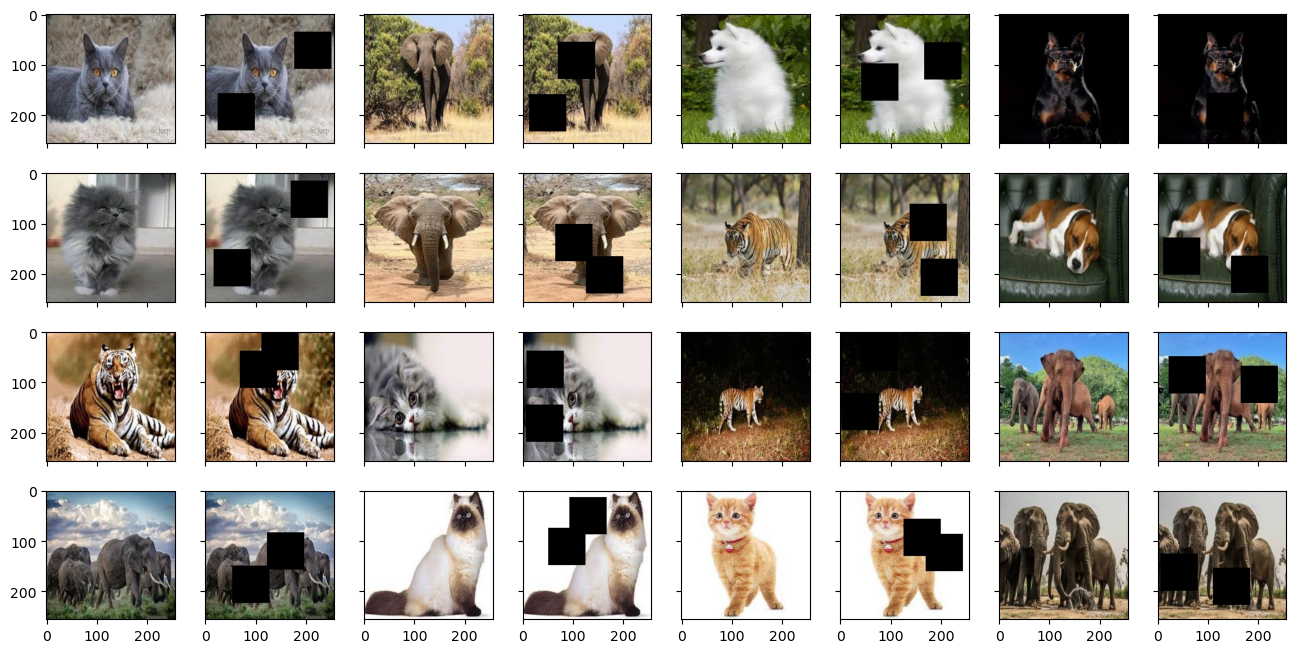

In [16]:
# Here, we are showing the 16 images from the first batch of (masked and corresponding unmasked) images.

temp_index = 0

IMG_masks, IMG_original = prep_train[temp_index]
sample_images = [None]*(len(IMG_masks)+len(IMG_original))
sample_images[::2] = IMG_original
sample_images[1::2] = IMG_masks
fig = plt.figure(figsize = (16., 8.))
grid = ImageGrid(fig, 111, nrows_ncols = (4, 8), axes_pad = 0.3, )

for ax, image in zip(grid, sample_images):
    ax.imshow(image)

plt.show()

# UNET Model

In [5]:
"""In tasks like Image reconstruction, two commonly used metrics are IoU (Intersection over Union) 
   and Dice Coefficient. In this model, Dice Coefficient is used whose goal is to maximize the area 
   of overlap between the predicted pixel and the ground truth pixel divided by their union. """

def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [6]:
# This class defines the UNET model

class inpaintingModel:
    def prepare_model(self, input_size=(256,256,3)):
        inputs = keras.layers.Input(input_size)

        conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
        conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 

        conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)

        outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

        return keras.models.Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = keras.layers.MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = keras.layers.concatenate([up, shared_layer], axis=3)

        return conv, up

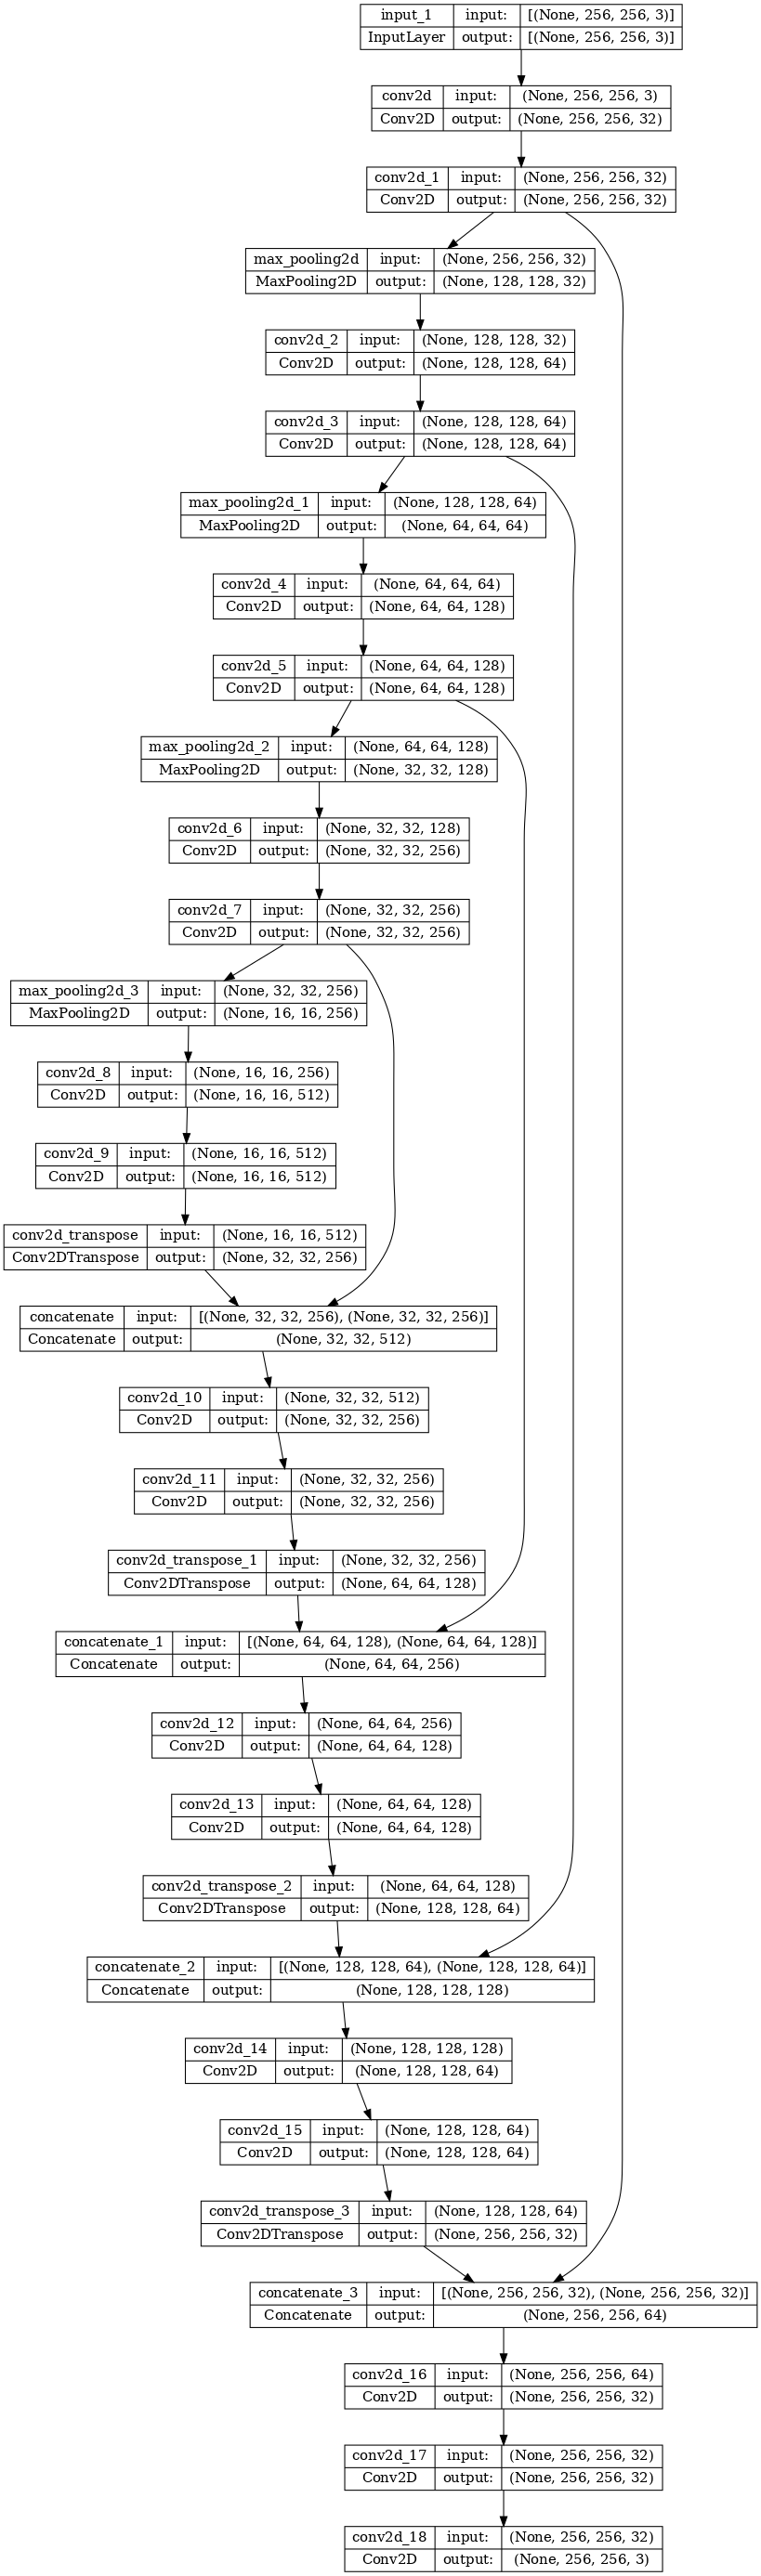

In [19]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

In [20]:
wandb.init(entity='sachinvashistha', project="Photo_reconstruction")

wandb: Currently logged in as: sachinvashistha. Use `wandb login --relogin` to force relogin


In [21]:
_ = model.fit(prep_train,
          epochs = 20, 
          steps_per_epoch = len(prep_train),
          use_multiprocessing = True,
          callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
218/218 [==============================] - 163s 601ms/step - loss: 0.0163 - dice_coef: 0.6245
Epoch 2/20
218/218 [==============================] - 136s 620ms/step - loss: 0.0058 - dice_coef: 0.6445
Epoch 3/20
218/218 [==============================] - 141s 639ms/step - loss: 0.0053 - dice_coef: 0.6458
Epoch 4/20
218/218 [==============================] - 140s 634ms/step - loss: 0.0048 - dice_coef: 0.6471
Epoch 5/20
218/218 [==============================] - 140s 634ms/step - loss: 0.0047 - dice_coef: 0.6475
Epoch 6/20
218/218 [==============================] - 141s 639ms/step - loss: 0.0045 - dice_coef: 0.6480
Epoch 7/20
218/218 [==============================] - 138s 627ms/step - loss: 0.0044 - dice_coef: 0.6482
Epoch 8/20
218/218 [==============================] - 137s 623ms/step - loss: 0.0042 - dice_coef: 0.6487
Epoch 9/20
218/218 [==============================] - 137s 622ms/step - loss: 0.0042 - dice_coef: 0.6482
Epoch 10/20
218/218 [==============================] - 

In [22]:
model.save(os.path.join(wandb.run.dir, "Image_Reconstruct_model.h5"))

In [23]:
wandb.save('Image_Reconstruct_model.h5')

['/kaggle/working/wandb/run-20230407_125444-kyuuzots/files/Image_Reconstruct_model.h5']

1/1 [==============================] - 0s 30ms/step


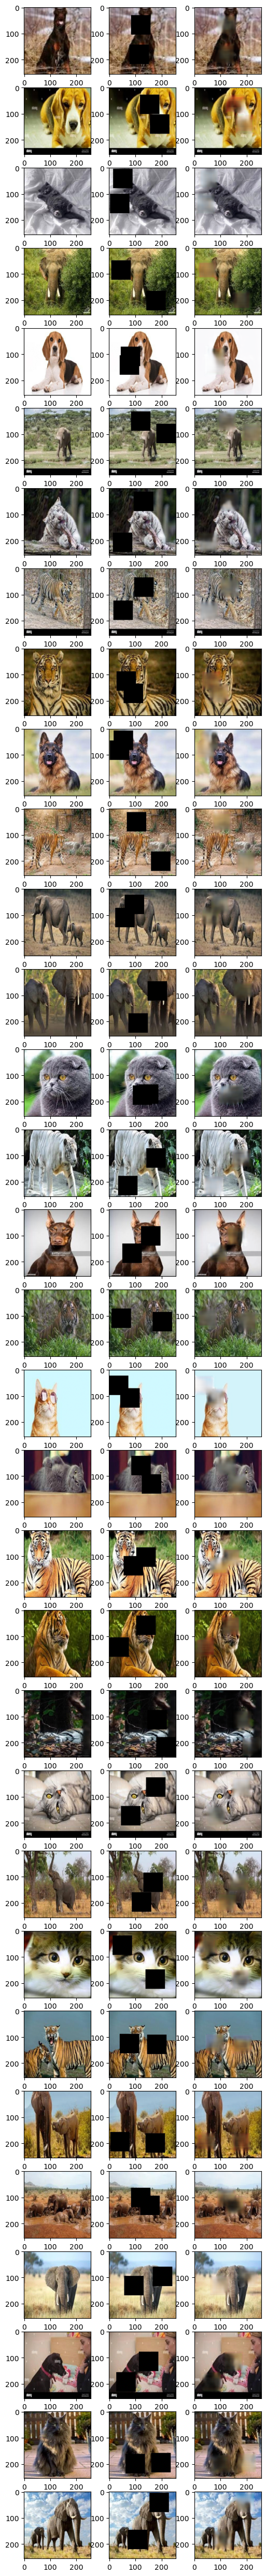

In [24]:
# Showing prediction on 32 images from training data (not from testing data)

rows = 32
sample_idx = 54
sample_images, sample_labels = prep_train[sample_idx]
#print(sample_images[0])
fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))

for i in range(32):
    impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
    #print(impainted_image.shape)
    axs[i][0].imshow(sample_labels[i])
    axs[i][1].imshow(sample_images[i])
    
    axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()

# Preparing submission file

In [8]:
# collect the test images

def load_test_data(path):
    Folder = path
    list_images = []
    list_image_names = []
    for File_name in os.listdir(Folder):
        if File_name.endswith('jpeg') or File_name.endswith('jpg') or File_name.endswith('png'):
            
            img = Image.open(os.path.join(Folder,File_name))
            if img is not None:
                list_images.append(asarray(img) / 255)
                list_image_names.append(File_name)
    return list_images, list_image_names


In [13]:
test_images, test_image_names = load_test_data(masked_test_path)

In [27]:
print(len(test_images))
print(len(test_image_names))

200
200


In [28]:
print(test_image_names[0])

Dog-Train (411).jpeg


In [14]:
# test image array contains 200 numpy arrays each of size (256, 256, 3)

test_image_array = asarray(test_images)
print(test_image_array.shape)
print(len(test_image_array))

(200, 256, 256, 3)
200


(256, 256, 3)


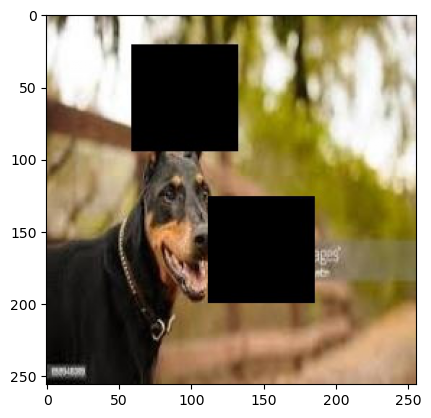

In [31]:
# showing a sample test image consisting of holes

temp_img = test_image_array[0]
print(temp_img.shape)
plt.imshow(temp_img)
plt.show()

In [32]:
"""Here, in this cell, we have used the trained UNET model to make prediction on test images.
   In later cells, we also show how to load model weights and then make prediction."""

import math

batchSize = 32
predicted_matrix = []
for a in range(0, math.floor(len(test_image_array) / batchSize) + 1):
    for b in range(0, batchSize):
        if len(test_image_array) - (b + 1 + (a * batchSize)) >= 0:
            predicted_matrix.append(model.predict(test_image_array[b + (a * batchSize)].reshape((1,) + test_image_array[b + (a * batchSize)].shape)))
            #print(test_image_names[b + (a * batchSize)])
            #print(b + (a * batchSize))

print(len(predicted_matrix))

1/1 [==============================] - 0s 25ms/step
200


In [33]:
# Reading the file "masked_info.csv" which contains info about the two holes of each test image.

df = pd.read_csv(masked_test_path + "masked_info.csv")
print(len(df))

200


In [34]:
""" This function create the list which contains info about the normalized pixel values predicted by the 
    model for the test images."""

def submission(file_name, matrix, r, c, no):
    
    temp_list = []
    for row in range(0, 75):
        for col in range(0, 75):
            channel = 0
            for ch in range(2, -1, -1):
                first_val = file_name + "_" + "box" + str(no) + "_" + str(row + r) + "_" + str(col + c) + "_" + str(channel)
                channel += 1
                second_val = matrix[:, :, ch][(row + r), (col + c)]
                temp_list.append([first_val, second_val])
                
    #print(temp_list)
    return temp_list
    

In [35]:
print(predicted_matrix[0].shape)
print(predicted_matrix[0][0, :].shape)
for i in range(3):
    print(predicted_matrix[0][0, :][:, :, i].shape)
    print("******************************")

(1, 256, 256, 3)
(256, 256, 3)
(256, 256)
******************************
(256, 256)
******************************
(256, 256)
******************************


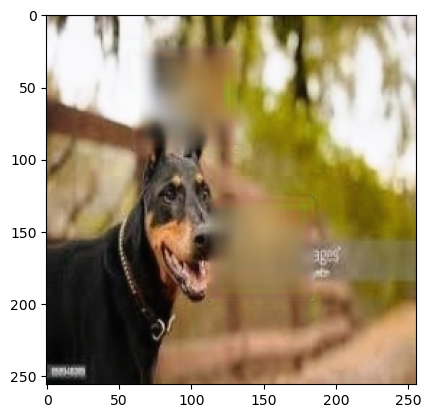

In [37]:
# showing the prediction of a test image (original image shown in one of the cells above)
#sample_image2 = Image.fromarray(predicted_matrix[0][0, :])
plt.imshow(predicted_matrix[0][0, :])
plt.show()

In [38]:
# This cell collects the list prepared by "submission(...)"" function, then converts it into a dataframe and write
# it into "photo_reconstruct_submission.csv" which we uploaded on the kaggle leaderboard.

final_list = []
for i in range(len(df)):
    index = test_image_names.index(df['filename'].iloc[i])
    #print(df['filename'].iloc[i])
    #print(index)
    
    box1_r = df['box1_row'].iloc[i]
    box1_c = df['box1_col'].iloc[i]
    box2_r = df['box2_row'].iloc[i]
    box2_c = df['box2_col'].iloc[i]
    
    list_b1 = submission(df['filename'].iloc[i], predicted_matrix[index][0, :], box1_r, box1_c, 1)
    list_b2 = submission(df['filename'].iloc[i], predicted_matrix[index][0, :], box2_r, box2_c, 2)
    final_list += (list_b1 + list_b2)
    
df_final = pd.DataFrame(final_list, columns =['filename_box_pixel', 'Value'], dtype = float)
#df_final = df_final.reset_index(drop=True, inplace = True)
df_final.to_csv("photo_reconstruct_submission.csv", index = False)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
# A check if all the values in the dataframe are normalized between 0 and 1

print(df_final["Value"].between(0,1).all())

True


In [40]:
# The length of the dataframe is 6750000 which is the required size.

print(len(df_final['Value']))

6750000


In [41]:
# This is a command to create a zip file named "Output_file.tar.gz" containing all files in the output directory of
# Kaggle.

!tar -zcvf Output_file.tar.gz /kaggle/working

tar: Removing leading `/' from member names
/kaggle/working/
/kaggle/working/wandb/
/kaggle/working/wandb/debug-internal.log
/kaggle/working/wandb/latest-run
/kaggle/working/wandb/run-20230407_125444-kyuuzots/
/kaggle/working/wandb/run-20230407_125444-kyuuzots/tmp/
/kaggle/working/wandb/run-20230407_125444-kyuuzots/tmp/code/
/kaggle/working/wandb/run-20230407_125444-kyuuzots/run-kyuuzots.wandb
/kaggle/working/wandb/run-20230407_125444-kyuuzots/files/
/kaggle/working/wandb/run-20230407_125444-kyuuzots/files/media/
/kaggle/working/wandb/run-20230407_125444-kyuuzots/files/media/graph/
/kaggle/working/wandb/run-20230407_125444-kyuuzots/files/media/graph/graph_summary_7a8bf9107efe4990ebd1.graph.json
/kaggle/working/wandb/run-20230407_125444-kyuuzots/files/conda-environment.yaml
/kaggle/working/wandb/run-20230407_125444-kyuuzots/files/output.log
/kaggle/working/wandb/run-20230407_125444-kyuuzots/files/wandb-summary.json
/kaggle/working/wandb/run-20230407_125444-kyuuzots/files/wandb-metadata.

In [82]:
# one line code to remove the "Output_file.tar.gz" after downloading it from Kaggle output directory.

os.remove("/kaggle/working/Output_file.tar.gz")

# Inference code: Loading model weights and testing it on test file

In [2]:
from tensorflow.keras.models import load_model

In [1]:
!pip install gdown

In [2]:
import gdown

In [3]:
url = "https://drive.google.com/u/1/uc?id=174yRThFRr7c3rjkGPkrN6ozzDfX_GQ_W&export=download"
output = "Image_Reconstruct_model.h5"
gdown.download(url, output)

Downloading...
From: https://drive.google.com/u/1/uc?id=174yRThFRr7c3rjkGPkrN6ozzDfX_GQ_W&export=download
To: /home/sachinvashisth/Downloads/Image_Reconstruct_model.h5
100%|██████████████████████████████████████| 93.3M/93.3M [01:11<00:00, 1.31MB/s]


'Image_Reconstruct_model.h5'

In [1]:
# Please change the path. 
# On Kaggle, it was "/kaggle/working/Image_Reconstruct_model.h5"

m_path = "/home/sachinvashisth/Downloads/Image_Reconstruct_model.h5"

In [7]:
savedModel = load_model(m_path, custom_objects = {'dice_coef': dice_coef})
print(savedModel.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

Please fill in the paths in the cell below and run all the cells after it and finally it will generate the desired submission file

In [4]:
inference_test_path = "PLEASE FILL IN THE PATH CONTAINING THE TEST IMAGES"
inference_file_path = "PLEASE FILL IN THE PATH WHERE \"masked_info.csv\" FILE IS LOCATED"

In [ ]:
inference_test_images, inference_test_image_names = load_test_data(inference_test_path)

In [ ]:
print(len(inference_test_images))
print(len(inference_test_image_names))

In [ ]:
inference_test_image_array = asarray(inference_test_images)
print(inference_test_image_array.shape)
print(len(inference_test_image_array))

In [ ]:
import math

batchSize = 32
inference_predicted_matrix_lm = []
for a in range(0, math.floor(len(inference_test_image_array) / batchSize) + 1):
    for b in range(0, batchSize):
        if len(inference_test_image_array) - (b + 1 + (a * batchSize)) >= 0:
            inference_predicted_matrix_lm.append(savedModel.predict(inference_test_image_array[b + (a * batchSize)].reshape((1,) + inference_test_image_array[b + (a * batchSize)].shape)))
            #print(inference_test_image_names[b + (a * batchSize)])
            #print(b + (a * batchSize))

print(len(inference_predicted_matrix_lm))

In [ ]:
df_inference = pd.read_csv(inference_file_path + "masked_info.csv")
print(len(df_inference))

In [ ]:
final_inference_list = []
for i in range(len(df_inference)):
    index = inference_test_image_names.index(df_inference['filename'].iloc[i])
    
    box1_r = df_inference['box1_row'].iloc[i]
    box1_c = df_inference['box1_col'].iloc[i]
    box2_r = df_inference['box2_row'].iloc[i]
    box2_c = df_inference['box2_col'].iloc[i]
    
    list_b1 = submission(df_inference['filename'].iloc[i], inference_predicted_matrix_lm[index][0, :], box1_r, box1_c, 1)
    list_b2 = submission(df_inference['filename'].iloc[i], inference_predicted_matrix_lm[index][0, :], box2_r, box2_c, 2)
    final_inference_list += (list_b1 + list_b2)
    
df_inference_final = pd.DataFrame(final_inference_list, columns =['filename_box_pixel', 'Value'], dtype = float)
df_inference_final.to_csv("inference_photo_reconstruct_submission.csv", index = False)
